## To try?
- Check and quantify the consistence between detectors (H1 and V1)
- Determine how far away the source of GW is
- https://www.gw-openscience.org/eventapi/html/allevents/

In [1]:
from gwpy.timeseries import TimeSeries
import numpy as np
import math
import matplotlib.pyplot as plt
import matplotlib.mlab as mlab
import h5py
import os

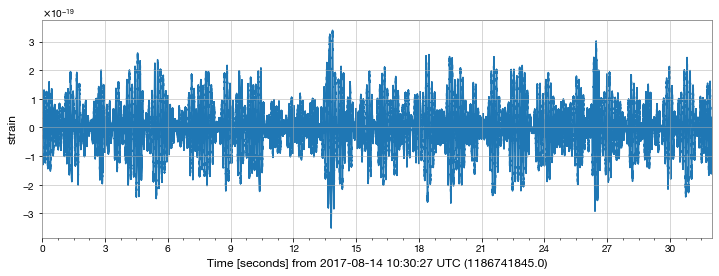

In [59]:
#----------------------------------------------------------------
# Set parameters
#----------------------------------------------------------------
fn = 'data/L-L1_GWOSC_4KHZ_R1-1186739814-4096.hdf5' # data file
tevent = 1186741861.5
#evtname = 'GW170608' # event name
#detector = 'H1' # detector: L1 or H1

#----------------------------------------------------------------
# Load LIGO data
#----------------------------------------------------------------
strain = TimeSeries.read(fn, format='hdf5.losc')
center = int(tevent)
strain = strain.crop(center-16, center+16)

#----------------------------------------------------------------
# Show LIGO strain vs. time
#----------------------------------------------------------------
plt.figure()
strain.plot()
plt.ylabel('strain')
plt.show()

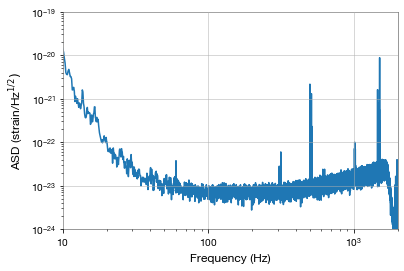

In [60]:
#----------------------------------------------------------------
# Obtain the power spectrum density PSD / ASD
#----------------------------------------------------------------

asd = strain.asd(fftlength=8)

plt.clf()
asd.plot()
plt.xlim(10, 2000)
plt.ylim(1e-24, 1e-19)
plt.ylabel('ASD (strain/Hz$^{1/2})$')
plt.xlabel('Frequency (Hz)')
plt.show()

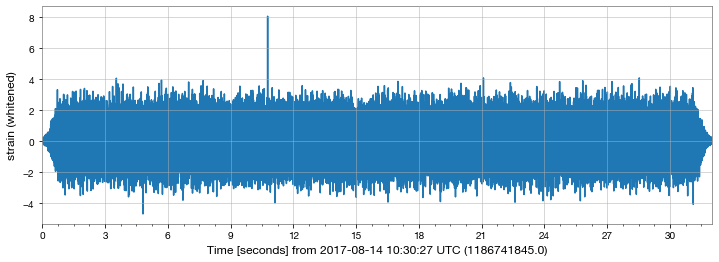

In [61]:
#----------------------------------------------------------------
# Whitening data
#----------------------------------------------------------------

white_data = strain.whiten()

plt.clf()
white_data.plot()
plt.ylabel('strain (whitened)')
plt.show()

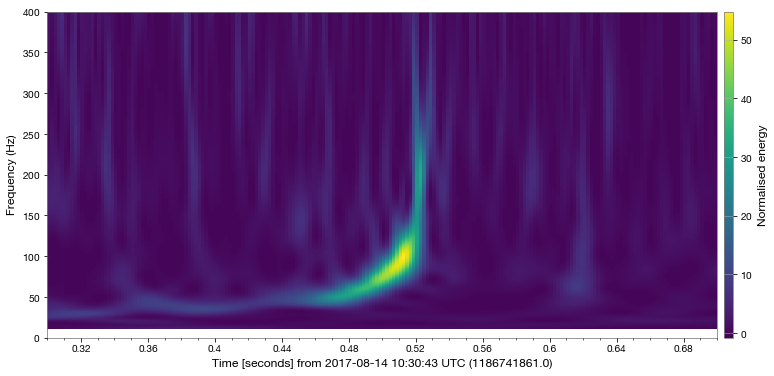

In [62]:
#----------------------------------------------------------------
# q-transform
#----------------------------------------------------------------

dt = 1  #-- Set width of q-transform plot, in seconds
hq = strain.q_transform(outseg=(tevent-dt, tevent+dt))

plt.clf()
fig = hq.plot()
ax = fig.gca()
fig.colorbar(label="Normalised energy")
ax.grid(False)
plt.xlim(tevent-0.2, tevent+0.2)
plt.ylim(0, 400)
plt.ylabel('Frequency (Hz)')
plt.show()

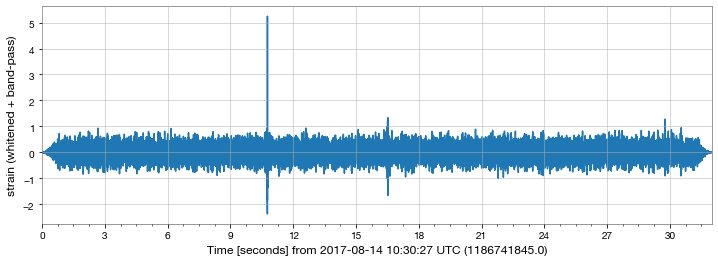

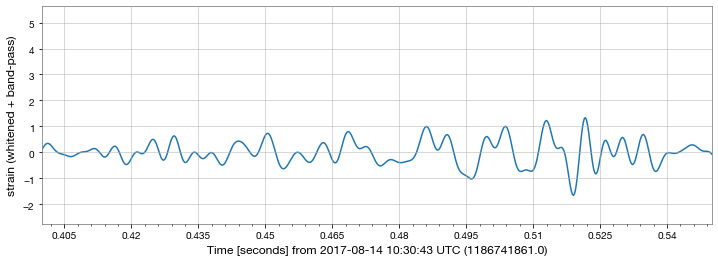

In [69]:
#----------------------------------------------------------------
# Bandpass filtering
#----------------------------------------------------------------

bandpass_low = 45
bandpass_high = 250

white_data_bp = white_data.bandpass(bandpass_low, bandpass_high)

plt.clf()
white_data_bp.plot()
plt.ylabel('strain (whitened + band-pass)')
plt.show()

plt.clf()
white_data_bp.plot()
plt.ylabel('strain (whitened + band-pass)')
plt.xlim(tevent-0.1, tevent+0.05)
plt.show()

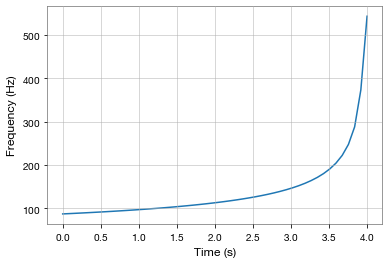

In [6]:
#----------------------------------------------------------------
# Frequency analytic
#----------------------------------------------------------------

def gwfreq(iM,iT,iT0,cutoff=3e-2):
    const = (948.5)*np.power((1./iM),5./8.)
    output = const*np.power(np.maximum((iT0-iT),cutoff),-3./8.)
    return output

times = np.linspace(0., 4., 50)
freq = gwfreq(20, times, 4)

plt.clf()
plt.plot(times, freq)
plt.xlabel('Time (s)')
plt.ylabel('Frequency (Hz)')
plt.show()

In [7]:
import lmfit

In [8]:
def osc(t, Mc, t0, C, phi):
    return C * np.power(Mc * gwfreq(Mc, t, t0), 10/3) * np.cos(gwfreq(Mc, t, t0) * (t0-t) + phi) * np.power(1e-40, np.heaviside(t - t0, 0) * (t - t0))

In [9]:
def osc_post(t, Mc, t0, C, phi):
    return C * np.power(Mc * gwfreq(Mc, t, t0, 10**(-2.9)), 10/3) * np.cos(gwfreq(Mc, t, t0, 10**(-2.9)) * (t0-t) + phi) * np.power(1e-90, np.heaviside(t - t0, 0) * (t - t0))

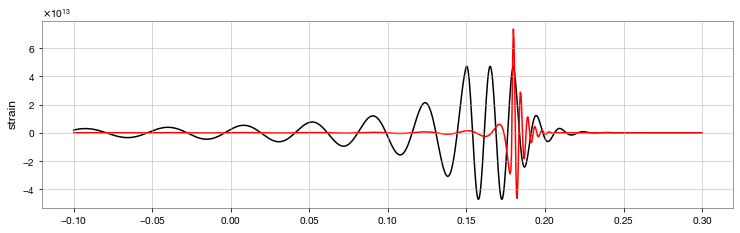

In [16]:
times = np.linspace(-0.1, 0.3, 1000)
freq = osc(times, 30, 0.18, 1, 0.0)
freq2 = osc_post(times, 30, 0.18, 0.03, 0.0)
plt.figure(figsize=(12, 4))
plt.subplots_adjust(left=0.1, right=0.9, top=0.85, bottom=0.2)
plt.plot(times, freq, 'k')
plt.plot(times, freq2, 'r')
#plt.xlabel('Time (s) since '+str(tevent))
plt.ylabel('strain')
plt.show()


In [17]:
def osc_dif(params, x, data, eps):
    iM=params['Mc']
    iT0=params['t0']
    norm=params['C']
    phi=params['phi']
    val=osc(x, iM, iT0, norm, phi)
    return (val-data)/eps

def osc_post_dif(params, x, data, eps):
    iM=params['Mc']
    iT0=params['t0']
    norm=params['C']
    phi=params['phi']
    val=osc_post(x, iM, iT0, norm, phi)
    return (val-data)/eps

[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 126
    # data points      = 614
    # variables        = 4
    chi-square         = 0.21241686
    reduced chi-square = 3.4822e-04
    Akaike info crit   = -4885.08853
    Bayesian info crit = -4867.40855
[[Variables]]
    Mc:   19.4182681 +/- 0.29631317 (1.53%) (init = 30)
    t0:   0.12102464 +/- 7.2821e-04 (0.60%) (init = 0.1)
    C:    2.3230e-14 +/- 1.3741e-15 (5.92%) (init = 1e-10)
    phi: -10.8688423 +/- 0.44168811 (4.06%) (init = 0)
[[Correlations]] (unreported correlations are < 0.100)
    C(t0, phi) = -0.979
    C(Mc, phi) =  0.870
    C(Mc, t0)  = -0.791
    C(Mc, C)   = -0.316
    C(C, phi)  = -0.272
    C(t0, C)   =  0.246


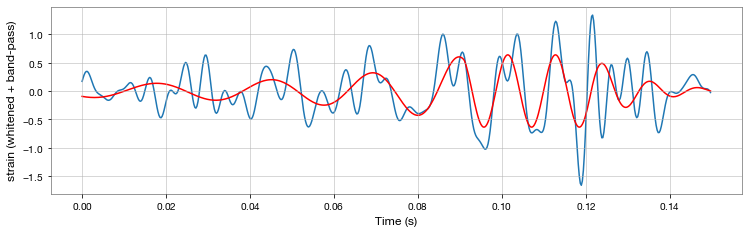

In [70]:
#----------------------------------------------------------------
# Naive Fit
#----------------------------------------------------------------

sample_times = white_data_bp.times.value
sample_data = white_data_bp.value
indxt = np.where((sample_times >= (tevent-0.1)) & (sample_times < (tevent+0.05)))
x = sample_times[indxt]
x = x-x[0]
white_data_bp_zoom = sample_data[indxt]

plt.figure(figsize=(12, 4))
plt.subplots_adjust(left=0.1, right=0.9, top=0.85, bottom=0.2)
plt.plot(x, white_data_bp_zoom)
plt.xlabel('Time (s)')
plt.ylabel('strain (whitened + band-pass)')

import lmfit
from lmfit import Model, minimize, fit_report, Parameters

model = lmfit.Model(osc)
p = model.make_params()
p['Mc'].set(30)     # Mass guess
p['t0'].set(0.1)  # By construction we put the merger in the center
p['C'].set(1e-10)      # normalization guess
p['phi'].set(0)    # Phase guess
unc = np.full(len(white_data_bp_zoom),20)
out = minimize(osc_dif, params=p, args=(x, white_data_bp_zoom, unc))
print(fit_report(out))
plt.plot(x, model.eval(params=out.params,t=x),'r',label='best fit')
plt.show()

[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 211
    # data points      = 164
    # variables        = 4
    chi-square         = 0.02637857
    reduced chi-square = 1.6487e-04
    Akaike info crit   = -1424.55143
    Bayesian info crit = -1412.15196
[[Variables]]
    Mc:   28.4702065 +/- 0.81854882 (2.88%) (init = 30)
    t0:   0.00167342 +/- 1.7969e-04 (10.74%) (init = 0)
    C:    6.0278e-16 +/- 4.5356e-17 (7.52%) (init = 1)
    phi:  0.04394729 +/- 0.24314888 (553.27%) (init = 1)
[[Correlations]] (unreported correlations are < 0.100)
    C(t0, phi) = -0.963
    C(Mc, C)   = -0.427
    C(Mc, t0)  = -0.272
    C(Mc, phi) =  0.173
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 146
    # data points      = 532
    # variables        = 4
    chi-square         = 0.13316036
    reduced chi-square = 2.5220e-04
    Akaike info crit   = -4403.79336
    Bayesian info crit = -4386.68678
[[Variables]]
    Mc:   20.4748841 +/- 0.3342

<Figure size 432x288 with 0 Axes>

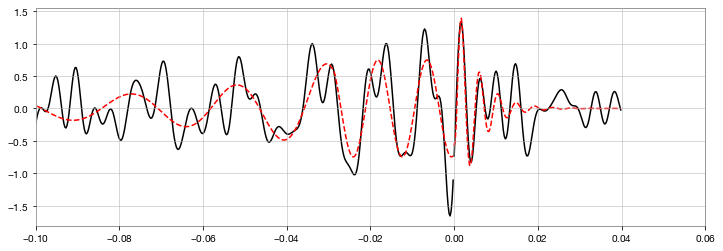

In [77]:
#NRtime, NR_H1 = np.genfromtxt('data/GW150914_4_NR_waveform.txt').transpose()
plt.clf()
plt.figure(figsize=(12, 4))
#plt.plot(NRtime, NR_H1)
plt.xlim(-0.1, 0.06)

indxtpost = np.where((sample_times >= (tevent+0.02)) & (sample_times < (tevent+0.06)))
xpost = sample_times[indxtpost]
xpt = xpost[0]
xpost = xpost-xpt
white_data_bp_zoom_post = sample_data[indxtpost]
plt.plot(xpost, white_data_bp_zoom_post, 'k')

indxtpre = np.where((sample_times >= (tevent-0.11)) & (sample_times < (tevent+0.02)))
xpre = sample_times[indxtpre]
xpre = xpre-xpt
white_data_bp_zoom_pre = sample_data[indxtpre]
plt.plot(xpre, white_data_bp_zoom_pre, 'k')

model = lmfit.Model(osc_post)
p = model.make_params()
p['Mc'].set(30)     
p['t0'].set(0)  
p['C'].set(1)
p['phi'].set(1)
out = minimize(osc_post_dif, params=p, args=(xpost, white_data_bp_zoom_post, np.full(len(white_data_bp_zoom_post),20)))
print(fit_report(out))
plt.plot(xpost, model.eval(params=out.params,t=xpost),'r--',label='best fit')

model = lmfit.Model(osc)
p = model.make_params()
p['Mc'].set(30)     
p['t0'].set(0)  
p['C'].set(1)
p['phi'].set(1)
out = minimize(osc_dif, params=p, args=(xpre, white_data_bp_zoom_pre, np.full(len(white_data_bp_zoom_pre),20)))
print(fit_report(out))
plt.plot(xpre, model.eval(params=out.params,t=xpre),'r--',label='best fit')
plt.show()